In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Veri dizinleri
train_dir = "/kaggle/input/clahe-esrgan-split-fundus-dataset/train"
test_dir = "/kaggle/input/clahe-esrgan-split-fundus-dataset/test"
img_size = (224, 224)
batch_size = 32
epochs = 50  # İlk eğitim için epoch sayısı

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 17524 files belonging to 8 classes.
Found 4384 files belonging to 8 classes.


In [2]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ResNet50 ve VGG16 modellerini yükle (transfer öğrenme)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Her iki modelin katmanlarını dondur
resnet_model.trainable = False
vgg_model.trainable = False

# Input layer
inputs = Input(shape=(224, 224, 3))

# ResNet50 ve VGG16 modellerini ayrı ayrı uygula
resnet_output = resnet_model(inputs)
vgg_output = vgg_model(inputs)

# ResNet50 ve VGG16 çıktılarını GlobalAveragePooling2D ile düzleştir
resnet_output = GlobalAveragePooling2D()(resnet_output)
vgg_output = GlobalAveragePooling2D()(vgg_output)

# İki modelin çıktılarını birleştir
combined = Concatenate()([resnet_output, vgg_output])

# Fully Connected Layer
x = Dense(512, activation='relu')(combined)
x = Dropout(0.5)(x)

# Output Layer
outputs = Dense(train_dataset.element_spec[1].shape[1], activation='softmax')(x)  # Sınıf sayısı

# Hibrit modeli oluştur
model = Model(inputs, outputs)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('hybrid_resnet50_vgg16.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 267s 452ms/step - accuracy: 0.7459 - loss: 0.9224 - val_accuracy: 0.8438 - val_loss: 0.3937
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 230s 419ms/step - accuracy: 0.8394 - loss: 0.4472 - val_accuracy: 0.8732 - val_loss: 0.3536
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 229s 418ms/step - accuracy: 0.8532 - loss: 0.4199 - val_accuracy: 0.8739 - val_loss: 0.3427
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 227s 414ms/step - accuracy: 0.8562 - loss: 0.3965 - val_accuracy: 0.8755 - val_loss: 0.3329
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 226s 412ms/step - accuracy: 0.8589 - loss: 0.3837 - val_accuracy: 0.8672 - val_loss: 0.3420
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 229s 417ms/step - accuracy: 0.8615 - loss: 0.3725 - val_accuracy: 0.8700 - val_loss: 0.3340
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 230s 420ms/step - accuracy: 0.8619 - loss: 0.3749 - val_accuracy: 

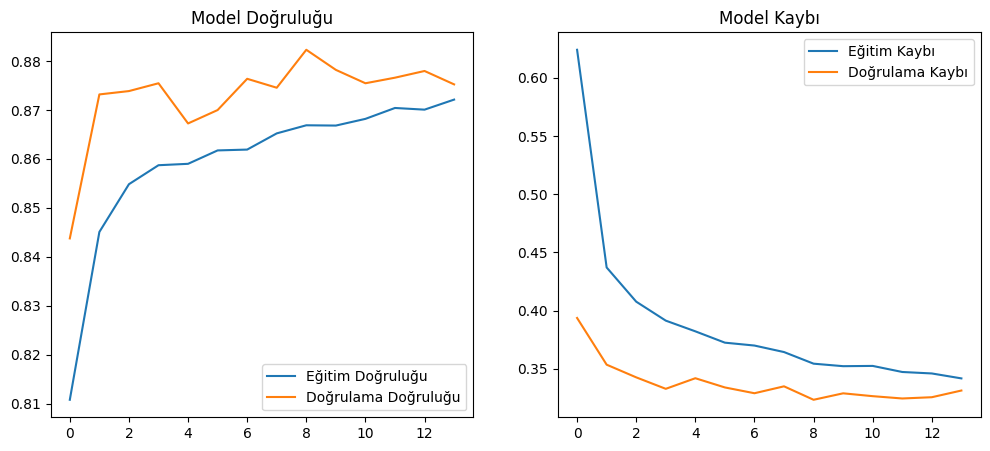

In [3]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

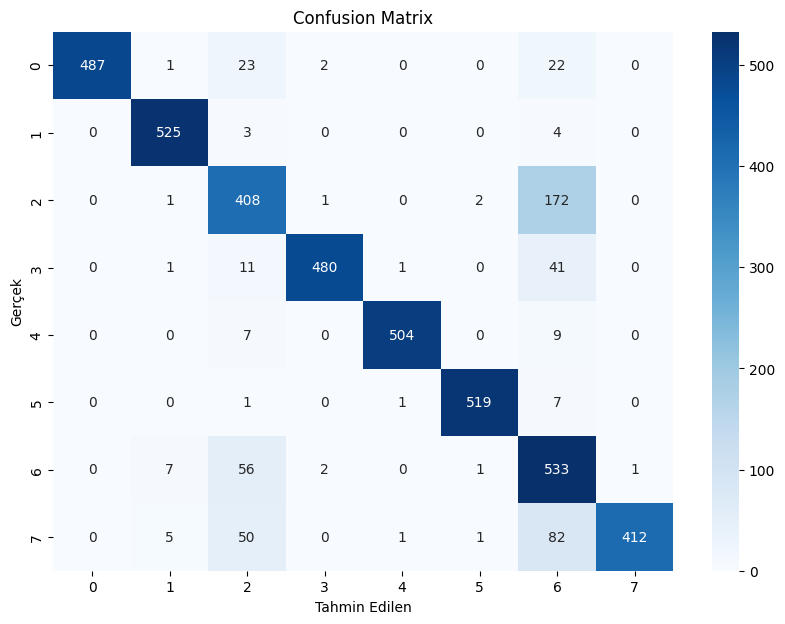

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)

# Confusion matrix'i görselleştir
plt.figure(figsize=(10, 7))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

Attention

In [5]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Concatenate, Multiply, Reshape, Activation, Conv2D, Add, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Channel Attention Layer
class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.global_avg_pool = GlobalAveragePooling2D()
        self.global_max_pool = tf.reduce_max
        self.dense1 = Dense(units=1, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense2 = Dense(units=1, kernel_initializer='he_normal', use_bias=False)
        self.reshape = Reshape((1, 1, -1))
        self.add = Add()
        self.activation = Activation('sigmoid')
        self.multiply = Multiply()

    def call(self, inputs):
        channel = inputs.shape[-1]
        
        # Global Average Pooling
        avg_pool = self.global_avg_pool(inputs)
        avg_pool = self.reshape(avg_pool)
        
        # Global Max Pooling
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        
        # Shared MLP
        avg_pool = self.dense1(avg_pool)
        max_pool = self.dense1(max_pool)
        
        avg_pool = self.dense2(avg_pool)
        max_pool = self.dense2(max_pool)
        
        # Add and Sigmoid
        channel_attention = self.add([avg_pool, max_pool])
        channel_attention = self.activation(channel_attention)
        
        return self.multiply([inputs, channel_attention])

# Spatial Attention Layer
class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.concat = Concatenate(axis=-1)
        self.conv = Conv2D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal')
        self.multiply = Multiply()

    def call(self, inputs):
        # Average Pooling and Max Pooling along the channel axis
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        
        # Concatenate along the channel axis
        concat = self.concat([avg_pool, max_pool])
        
        # Convolution layer
        spatial_attention = self.conv(concat)
        
        return self.multiply([inputs, spatial_attention])

# ResNet50 ve VGG16 modellerini yükle (transfer öğrenme)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Her iki modelin katmanlarını dondur
resnet_model.trainable = False
vgg_model.trainable = False

# Input layer
inputs = Input(shape=(224, 224, 3))

# ResNet50 ve VGG16 modellerini ayrı ayrı uygula
resnet_output = resnet_model(inputs)
vgg_output = vgg_model(inputs)

# Channel Attention ekle
resnet_output = ChannelAttention(ratio=8)(resnet_output)
vgg_output = ChannelAttention(ratio=8)(vgg_output)

# Spatial Attention ekle
resnet_output = SpatialAttention(kernel_size=7)(resnet_output)
vgg_output = SpatialAttention(kernel_size=7)(vgg_output)

# ResNet50 ve VGG16 çıktılarını GlobalAveragePooling2D ile düzleştir
resnet_output = GlobalAveragePooling2D()(resnet_output)
vgg_output = GlobalAveragePooling2D()(vgg_output)

# İki modelin çıktılarını birleştir
combined = Concatenate()([resnet_output, vgg_output])

# Fully Connected Layer
x = Dense(512, activation='relu')(combined)
x = Dropout(0.5)(x)

# Output Layer
outputs = Dense(train_dataset.element_spec[1].shape[1], activation='softmax')(x)  # Sınıf sayısı

# Hibrit modeli oluştur
model = Model(inputs, outputs)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('hybrid_resnet50_vgg16_with_attention.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 249s 430ms/step - accuracy: 0.7384 - loss: 0.8006 - val_accuracy: 0.8572 - val_loss: 0.3722
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 230s 419ms/step - accuracy: 0.8464 - loss: 0.4338 - val_accuracy: 0.8736 - val_loss: 0.3500
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 228s 415ms/step - accuracy: 0.8552 - loss: 0.4044 - val_accuracy: 0.8759 - val_loss: 0.3402
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 226s 411ms/step - accuracy: 0.8574 - loss: 0.3833 - val_accuracy: 0.8791 - val_loss: 0.3344
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 227s 414ms/step - accuracy: 0.8613 - loss: 0.3773 - val_accuracy: 0.8641 - val_loss: 0.3435
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 229s 418ms/step - accuracy: 0.8619 - loss: 0.3680 - val_accuracy: 0.8695 - val_loss: 0.3374
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 230s 419ms/step - accuracy: 0.8662 - loss: 0.3621 - val_accuracy: 0.8675 - val_loss: 0.3375
Epoch 8/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 228s 415ms/step - accuracy: 0.8657 -

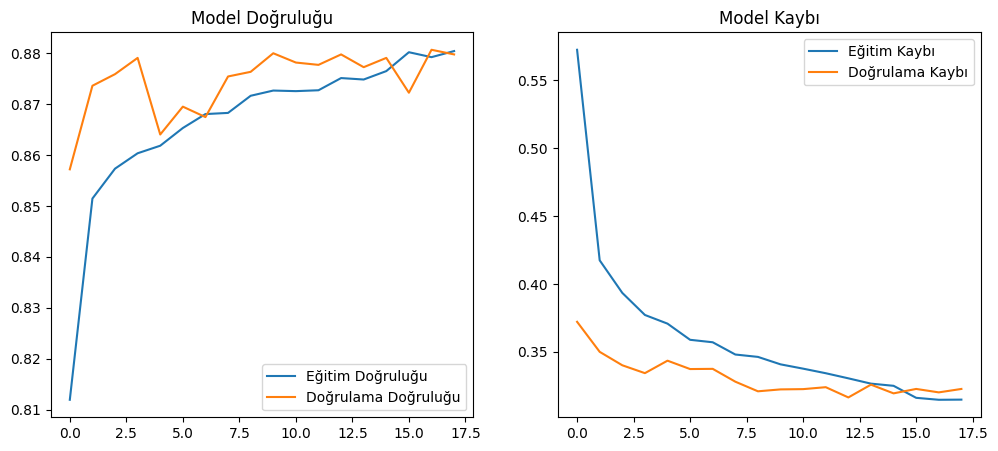

In [6]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━

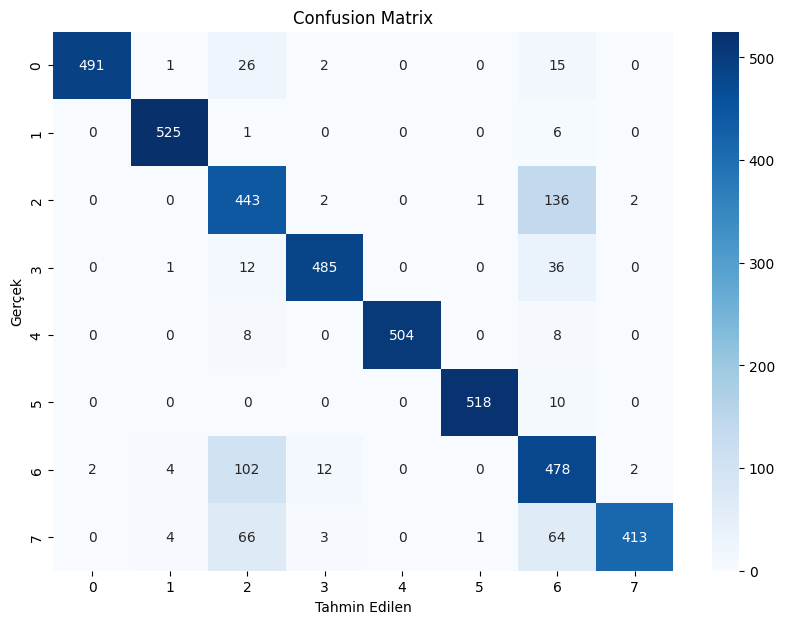

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)

# Confusion matrix'i görselleştir
plt.figure(figsize=(10, 7))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()